#differentially private linear regression using sufficient statistics

> Indented block




In [ ]:
# import libraries and set path
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import normalize
from scipy import stats
 
#setting parameters
datapath="drive/My Drive/synthetic_data.csv"
d=100
n=1000
L=1 
sigma=1 
alpha=0.001
epsilon=2
mean=0
 
norm='l1'
axis=1
test_size=0.3

Mounted at /content/drive


## **Data being released by owner**

In [ ]:
# loading data
def load_data(n,d,datapath):
 #importing dataset and reading it into a Data Frame and converting to array and creating a subset of required size
 dataset=pd.read_csv(datapath)
 X0=1
 arr0=dataset.to_numpy()
 col_nums= len(arr0[0])
 #print(col_nums)
 arr0=np.delete(arr0, 0, axis=1)# Deleting  first column as it contains indices from dataframe
 y=arr0[0:n,col_nums-2]
 y=y.reshape(n,1)
 arr1=arr0[0:n,0:d]
 arr1=np.insert(arr1,0,X0,axis=1) #inserting first column as all zeros for linear regression
 arr1=arr1.reshape(n,d+1)
 return(arr1,y)


#The data with the data owner
def preprocess_x(x,norm,axis):
  x_norm=normalize(x,norm='l2',axis=1)
  return(x_norm)

# compute sufficient stats for LRCF
def suff_stats_LR(x,y):
 XTX=np.dot(x.transpose(),x)
 XTY=np.dot(x.transpose(),y)
 return(XTX,XTY)


def get_raw_data(n,d,datapath,norm,axis,test_size):
  x,y=load_data(n,d,datapath)

  x = preprocess_x(x,norm,axis)

  #Splitting into test and train data
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=42)


  return(x_train,x_test,y_train,y_test)

def clipping_trick(data,max_value,min_value):
  for i in range(len(data)):
    if data[i]>max_value:
     data[i]=max_value
    elif data[i]<min_value:
     data[i]=min_value 
  return(data)     

def get_data(n,d,datapath,norm,axis,test_size,y_max,y_min):
  x_train,x_test,y_train,y_test = get_raw_data(n,d,datapath,norm,axis,test_size)
  y_train_clipped=clipping_trick(y_train,y_max,y_min)
  y_test_clipped=clipping_trick(y_test,y_max,y_min)
  XtX, XtY = suff_stats_LR(x_train,y_train_clipped)
  return(XtX, XtY, x_test, y_test,y_test_clipped)

# **Privacy wall**

In [ ]:
# Laplace mechanism
# sensitivity of sufficient stats
#L1 Sensitivity of XTX and XTy
def LR_suff_stat_l1_sensitivity(d,y_max):
 l1_sensi_xtx=(d)*(d+1)/2                       #formula is (xmax)^2(d)*(d+1)/2(our xmax =1 as we have arready normalized)
 l1_sensi_xty=d*y_max                        #formula is xmax*ymax*d(our xmax =1 as we have arready normalized)
 return(l1_sensi_xtx,l1_sensi_xty)
 

# laplace mechanism(adding laplacian noise) 
def add_laplacian_noise(x,mean,scale):  
 noisy_x=np.random.laplace(mean,scale,(len(x),len(x[0])))+x
 return(noisy_x)

def laplace_mechanism(XtX, XtY, mean, epsilon, d, y_max):
  x_dim=d
  l1_sensi_xtx,l1_sensi_xty=LR_suff_stat_l1_sensitivity(x_dim,y_max)
  
  scale_XtX=l1_sensi_xtx/(epsilon/2)
  XtX_diff = add_laplacian_noise(XtX,mean,scale_XtX)

  scale_XtY=l1_sensi_xty/(epsilon/2)
  XtY_diff = add_laplacian_noise(XtY,mean,scale_XtY)

  return(XtX_diff, XtY_diff)

# **Analysis by Analyst**

In [ ]:
,#Analysis by Analyst
# Train the model 

# LRCF that takes sufficient stats as input 
def LRCF_suff_stats_train(XTX, XTY, epsilon, mean, privacy, d, y_max):
 if privacy==1:
  XtX_diff,XtY_diff=laplace_mechanism(XTX, XTY, mean, epsilon, d, y_max) 
  XTX=XtX_diff
  XTY=XtY_diff
 W=np.dot(np.linalg.inv(XTX),XTY)
 W = W.reshape(1,d+1)
 return(W)


def LR_predict(W, x):
 ycap= np.zeros((len(x),),dtype=float)
 ycap=ycap.reshape(len(x),1)
 for i in range(len(x)):
  for k in range(len(x[0])):
   ycap[i,0]=ycap[i,0]+(W[0,k]*x[i,k])
 return(ycap)  


# **Analysis of Results**

In [ ]:
# Error functions

#RMSE
def compute_rmse(w,y_test, y_pred):
 sum=0
 test_len=len(y_test)
 y_test=y_test.reshape(test_len,1)
 for i in range(test_len):
  sum=sum+((y_test[i,0]-y_pred[i,0] )**2) 
 rmse=math.sqrt(sum/test_len)
 return(rmse)



#Spearman rank correlation
def compute_rank_corr(y_test, y_pred):
  src = stats.spearmanr(y_test, y_pred)
  return(src)


#Plots

In [ ]:
def plt_corr(y_test,y_pred_priv):
 fig=plt.figure()
 plt.xlabel('Original y')
 plt.ylabel('predicted y')
 plt.scatter(y_test,y_pred_priv)

def vary_epsilon(initial_value,final_value): 
 fig=plt.figure(figsize=[10,5])
 ax1 = fig.add_subplot(121)
 ax2 = fig.add_subplot(122)
 ax1 = fig.add_subplot(121)
 ax2 = fig.add_subplot(122)
 ax1.set_xlabel('e')
 ax1.set_ylabel('RMSE')
 ax1.set_title('Epsilon vs RMSE')
 ax2.set_xlabel('e')
 ax2.set_ylabel('Spearman rank corelation coefficient')
 ax2.set_title('Epsilon vs Datasize')
 e_values=np.linspace(initial_value,final_value,200)

 for i in range(len(e_values)):
  W_priv = LRCF_suff_stats_train(XtX, XtY, e_values[i], mean, 1, d, y_max)
  y_pred_priv=LR_predict(W_priv, x_test)
  error=compute_rmse(W_priv,y_test, y_pred_priv)
  rank_corr=compute_rank_corr(y_test, y_pred_priv)
  ax1.scatter(e_values[i],error)
  ax2.scatter(e_values[i],rank_corr[0]) 

def vary_datasize(initial_size,final_size):
  fig=plt.figure(figsize=[20,5])
  ax1 = fig.add_subplot(141)
  ax2 = fig.add_subplot(142)
  ax3 = fig.add_subplot(143)
  ax4 = fig.add_subplot(144)
 
  ax1.set_xlabel('n')
  ax1.set_ylabel('RMSE')
  ax1.set_title('private datasize vs RMSE')
  ax2.set_xlabel('n')
  ax2.set_ylabel('Spearman rank corelation coefficient')
  ax2.set_title('private corelation coefficient vs Datasize')
  ax3.set_xlabel('n')
  ax3.set_ylabel('RMSE')
  ax3.set_title('Non private datasize vs RMSE')
  ax4.set_xlabel('n')
  ax4.set_ylabel('Spearman rank corelation coefficient')
  ax4.set_title('nNon private corelation coefficient vs Datasize')
  n=initial_size
  while (n<=final_size):
   x,y=load_data(n,d,datapath)
   x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=42)
   XtX, XtY, x_test, y_test = get_data(n,d,datapath,norm,axis,test_size)
   W_priv = LRCF_suff_stats_train(XtX, XtY, epsilon, mean, 1, d, y_max)
   W_nonpriv = LRCF_suff_stats_train(XtX, XtY, epsilon, mean, 0, d, y_max)
   y_pred_priv = LR_predict(W_priv, x_test)
   y_pred_nonpriv = LR_predict(W_nonpriv, x_test)
   error_priv = compute_rmse(W_priv,y_test, y_pred_priv)
   error_nonpriv = compute_rmse(W_nonpriv,y_test, y_pred_nonpriv)
   rank_corr_nonpriv=compute_rank_corr(y_test, y_pred_nonpriv)
   rank_corr=compute_rank_corr(y_test, y_pred_priv)
   ax1.scatter(n,error_priv,color='blue')
   ax2.scatter(n,rank_corr[0],color='blue')
   ax3.scatter(n,error_nonpriv,color='blue')
   ax4.scatter(n,rank_corr_nonpriv[0],color='blue')
   n=n+1

def vary_dim(initial_size,final_size):
  fig=plt.figure(figsize=[20,5])
  d=initial_size
  ax1 = fig.add_subplot(141)
  ax2 = fig.add_subplot(142)
  ax3 = fig.add_subplot(143)
  ax4 = fig.add_subplot(144)
  ax1.set_xlabel('d')
  ax1.set_ylabel('RMSE')
  ax1.set_title('private dimension vs RMSE')
  ax2.set_xlabel('d')
  ax2.set_ylabel('Spearman rank corelation coefficient')
  ax2.set_title('private corelation coefficient vs Datasize')
  ax3.set_xlabel('d')
  ax3.set_ylabel('RMSE')
  ax3.set_title('Non private dimensions vs RMSE')
  ax4.set_xlabel('d')
  ax4.set_ylabel('Spearman rank corelation coefficient')
  ax4.set_title('nNon private corelation coefficient vs Datasize')
  while (d<=final_size):
   x,y=load_data(n,d,datapath)
   x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=42)
   XtX, XtY, x_test, y_test = get_data(n,d,datapath,norm,axis,test_size)
   W_priv = LRCF_suff_stats_train(XtX, XtY, epsilon, mean, 1, d, y_max)
   W_nonpriv = LRCF_suff_stats_train(XtX, XtY, epsilon, mean, 0, d, y_max)
   y_pred_nonpriv = LR_predict(W_nonpriv, x_test)
   y_pred_priv = LR_predict(W_priv, x_test)
   error_priv = compute_rmse(W_priv,y_test, y_pred_priv)
   error_nonpriv = compute_rmse(W_nonpriv,y_test, y_pred_nonpriv)
   rank_corr=compute_rank_corr(y_test, y_pred_priv)
   rank_corr_nonpriv=compute_rank_corr(y_test, y_pred_nonpriv)
   ax1.scatter(d,error_priv,color='blue')
   ax2.scatter(d,rank_corr[0],color='blue')
   ax3.scatter(d,error_nonpriv,color='blue')
   ax4.scatter(d,rank_corr_nonpriv[0],color='blue')
   d=d+1
   

# **The Main** 

In [ ]:

#The Main 

y_max=1
y_min=-1
XtX, XtY, x_test, y_test,y_test_clipped = get_data(n,d,datapath,norm,axis,test_size,y_max,y_min)

W_priv = LRCF_suff_stats_train(XtX, XtY, epsilon, mean, 1, d, y_max)
W_nonpriv = LRCF_suff_stats_train(XtX, XtY, epsilon, mean, 0, d, y_max)

y_pred_priv = LR_predict(W_priv, x_test)
y_pred_nonpriv = LR_predict(W_nonpriv, x_test)

error_priv = compute_rmse(W_priv,y_test, y_pred_priv)
error_nonpriv = compute_rmse(W_nonpriv,y_test, y_pred_nonpriv)
error_nonpriv



0.646059664175075

In [ ]:
#Plotting correlation in x and y and calculating spearman rank corelation coefficient
compute_rank_corr(y_test, y_pred_priv)


SpearmanrResult(correlation=0.07455558251104816, pvalue=0.17665976881443599)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


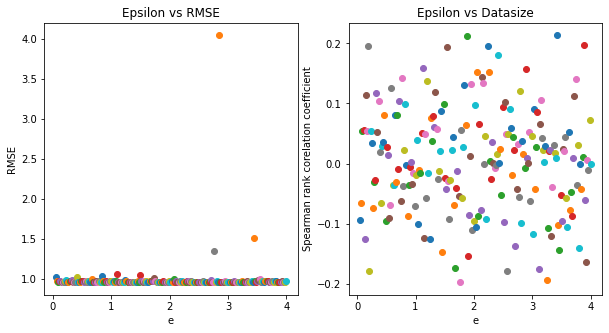

In [ ]:
# effect of varying e
initial_value=0.05
final_value=4
vary_epsilon(initial_value,final_value)

In [ ]:
#effect of varying data size
initial_size=200
final_size=500
vary_datasize(initial_size,final_size)

In [ ]:
 
#effect of varing dimensions
initial_dim=2
final_dim=100
vary_dim(initial_dim,final_dim)